# Realtime car detection using deeplearning

In last post [Car Detection using HOG](https://github.com/AvishekParajuli/SmartCar_proj/tree/master/cardetection) we examined HOG features with SVM to detect car. However, that approach had several disadvantages such as large false alarm(false positives), scale invariance(to some degree), viewpoint dependency (lack of generality).

In todays' post we will examine deeplearning based object detection methods to detect car and other objects in realtime using CPU only

The current state of art methods for object detection are i) Faster R-CNN, ii) Single Shot Multi-Box Detector, SSD, and iii) YOLO. Faster R-CNN is the the most accurate but is the slowest. Recently released YOLOv3 architecture is fast (realtime in GPU not CPU) but the accuray is a concern for overlapping and small sized objects. SSD based method seems to be a good a compromise between accuracy and speed. For this post, we would be choosing **a pretrained SSD MobileNet model** which is a downsized model optimized to run on mobile devices with less computing power. It takes ~45 ms on CPU for forward propogation. Even the full SSD model trained on coco dataset takes about 300-450 ms on cpu which is comparable to yolov3.

Let's begin by loading the necessary packages:


In [4]:
import numpy as np
import argparse
import cv2
import matplotlib.pyplot as plt
import time
# Config the matplotlib backend as plotting inline in IPython
#%matplotlib inline

Feed the input parameters and theri location

In [5]:
# manually feed the input params and other default parameters

mImageName = './images/example_01.jpg' #default input image
mModelName = './ssd/mobile-net/MobileNetSSD_deploy.caffemodel' #loction of the MobileNetSSD model
mModelWeightsName ='./ssd/mobile-net/MobileNetSSD_deploy.prototxt.txt'# location of model weight file

# initialize the list of class labels MobileNet SSD was trained to
# detect, then generate a set of bounding box colors for each class
CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat","bottle", "bus", 
           "car", "cat", "chair", "cow", "diningtable","dog", "horse", "motorbike", 
           "person", "pottedplant", "sheep","sofa", "train", "tvmonitor"]
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))# random colors for each classes

Now lets load the image

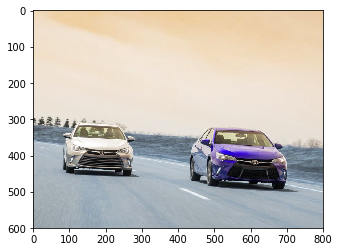

In [6]:
#load image using opencv
image = cv2.imread(mImageName,cv2.IMREAD_COLOR)
(h, w) = image.shape[:2] # save the input image height and width
plt.imshow(image)
plt.show()


I typically always read an image and display it immediately before moving further. This helps to check the input, get feedback and avoid any other issues later in the algorithm.
This is necessary because in opencv-python, failure to load image will not error out. Therefore, atleast during development i typicall print and output intermediate results. 

I have developed this habit after learning from years of experience working in this field of computer vision. And this habit has saved me a lot of time to avoid issues before they get  bigger and become hard to debug.

However, there is an aditional issue with the input image. Did anyone of you notice it after display?

#### The problem with the above display is that the R and B channels are swapped during display only. This is because the matplotlib uses the default RGB channels while the opencv uses BGR. 
Next we will write a function that does the conversion and handles the image display part.

In [13]:
#global variables
usematplotDisp = True #to control display using opencv or matplotlib
figureCount = 1

def convertToRGB(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#define function that we can use to control display using opencv or matplotlib
def imShow(img, windowName ='newWindow', newWindow= False):
    global figureCount
    if(usematplotDisp):
        if(newWindow):
            figureCount += 1 #increment count
        plt.ion()
        #plt.figure(1)
        if(img.ndim is 3):
            plt.imshow(convertToRGB(img))
        else:
            plt.imshow(img)
        plt.title(windowName)
        plt.show()
    else:
        #here we use opencv
        cv2.namedWindow(windowName, cv2.WINDOW_NORMAL)
        cv2.imshow(windowName, img)


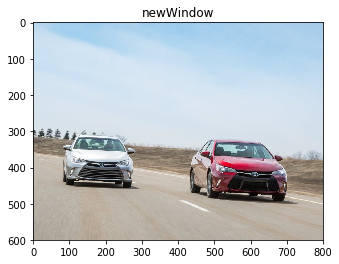

In [14]:
#now lets check the display again
imShow(image)

Now this looks better; Notice how the color of the red and blue car have swapped

We will now move to buisness and load the model, pretrained weights

In [15]:
# load the pretrained model
print("[INFO] loading model...")
net = cv2.dnn.readNetFromCaffe(mModelWeightsName, mModelName)

[INFO] loading model...


In [22]:
#query the net object to check if it is successfully loaded
layersName = net.getLayerNames()
# now print the last layername to check if the net was successfully detected
print(layersName[-1])

detection_out


### Now, we need to create a blob(input 3d volume) to be passed to the opencv dnn. This requires some explanation!

The function signature is:
_blob = cv2.dnn.blobFromImage(image, scalefactor=1.0, size, mean, swapRB=True)_
- image: input image
- scalingfactor: exact scale factor used by authors when they trained the model
- size : size at which the model was trained; input image will eb resized to this sized internally
- mean:  mean substraction value for each of the channels
- swapRB:  need to swapRB values

[see table for choice of scaling, mean, and swapRB](https://github.com/opencv/opencv/tree/master/samples/dnn#object-detection)

In [26]:
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 0.007843, (300, 300), 127.5)
# pass the blob through the network and obtain the detections and
# predictions
print("[INFO] computing object detections...")
net.setInput(blob)
start_time = time.time()
detections = net.forward()
print("[INFO] ForwardNet pass took %0.3f seconds." %(time.time()-start_time))

[INFO] computing object detections...
[INFO] ForwardNet pass took 0.071 seconds.


** At this time, the detections are done; now we need to draw a bounding box so that we can see them.
I won't believe until i see them, bruh!

Lets define a function to draw the bounidng box and print the objects on top.

In [41]:
#define probabaility threshold for detection
mProb = 0.2 

def drawSSDBox(image, detections):
    (h, w) = image.shape[:2] # save the input image height and width
    # loop over the detections
    for i in np.arange(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with the
        # prediction
        confidence = detections[0, 0, i, 2]

        # filter out weak detections by ensuring the `confidence` is
        # greater than the minimum confidence
        if confidence > mProb:
            # extract the index of the class label from the `detections`,
            # then compute the (x, y)-coordinates of the bounding box for
            # the object
            idx = int(detections[0, 0, i, 1])
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # display the prediction
            label = "{}: {:.2f}%".format(CLASSES[idx], confidence * 100)
            print("[INFO] {}".format(label))
            cv2.rectangle(image, (startX, startY), (endX, endY),
                COLORS[idx], 2)
            y = startY - 15 if startY - 15 > 15 else startY + 15
            cv2.putText(image, label, (startX, y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[idx], 2)



[INFO] car: 99.96%
[INFO] car: 95.68%


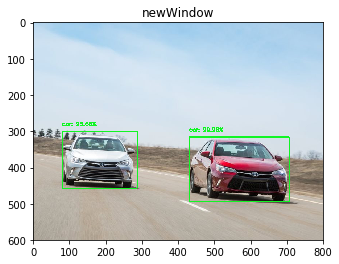

In [44]:
drawSSDBox(image, detections)
imShow(image)

Damn, this accurately detected to cars with high confidence level.
This model can detect other  objects which were defined in the list CLASSES before.

CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat","bottle", "bus", 
           "car", "cat", "chair", "cow", "diningtable","dog", "horse", "motorbike", 
           "person", "pottedplant", "sheep","sofa", "train", "tvmonitor"]
           
Now, lets wrap the above code in a manageable function.

[INFO] computing object detections...
[INFO] ForwardNet pass took 0.069 seconds.
[INFO] car: 99.96%
[INFO] car: 99.28%


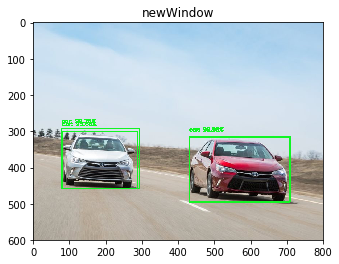

In [45]:
def processImage(image):
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 0.007843, (300, 300), 127.5)
    # pass the blob through the network and obtain the detections and
    # predictions
    print("[INFO] computing object detections...")
    net.setInput(blob)
    start_time = time.time()
    detections = net.forward()
    print("[INFO] ForwardNet pass took %0.3f seconds." %(time.time()-start_time))
    drawSSDBox(image, detections)

# lets test the function
processImage(image)
imShow(image)

Now, lead a new image and detect objects into it

[INFO] computing object detections...
[INFO] ForwardNet pass took 0.078 seconds.
[INFO] car: 96.92%
[INFO] car: 96.69%
[INFO] car: 93.84%
[INFO] car: 80.98%


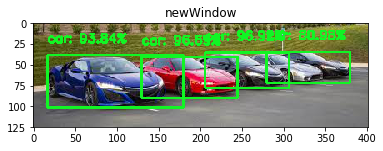

In [46]:
mImageName = './images/cars_audi.jpg'
image = cv2.imread(mImageName,cv2.IMREAD_COLOR)
processImage(image)
imShow(image)

Thats' all for today.

If you would like to check the yolov3 object detection, here is the [link](https://github.com/AvishekParajuli/object-detect/blob/master/yolo/yolov3_opencv_objdetect.py).

Next, we will see how to train an object detection model using one of these NN architectures.